# Q1. Technical Indicators

In [66]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

/tmp/ipython-input-54210002.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('TCS.NS', start='2023-01-01', end='2023-12-31', interval='1d', multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


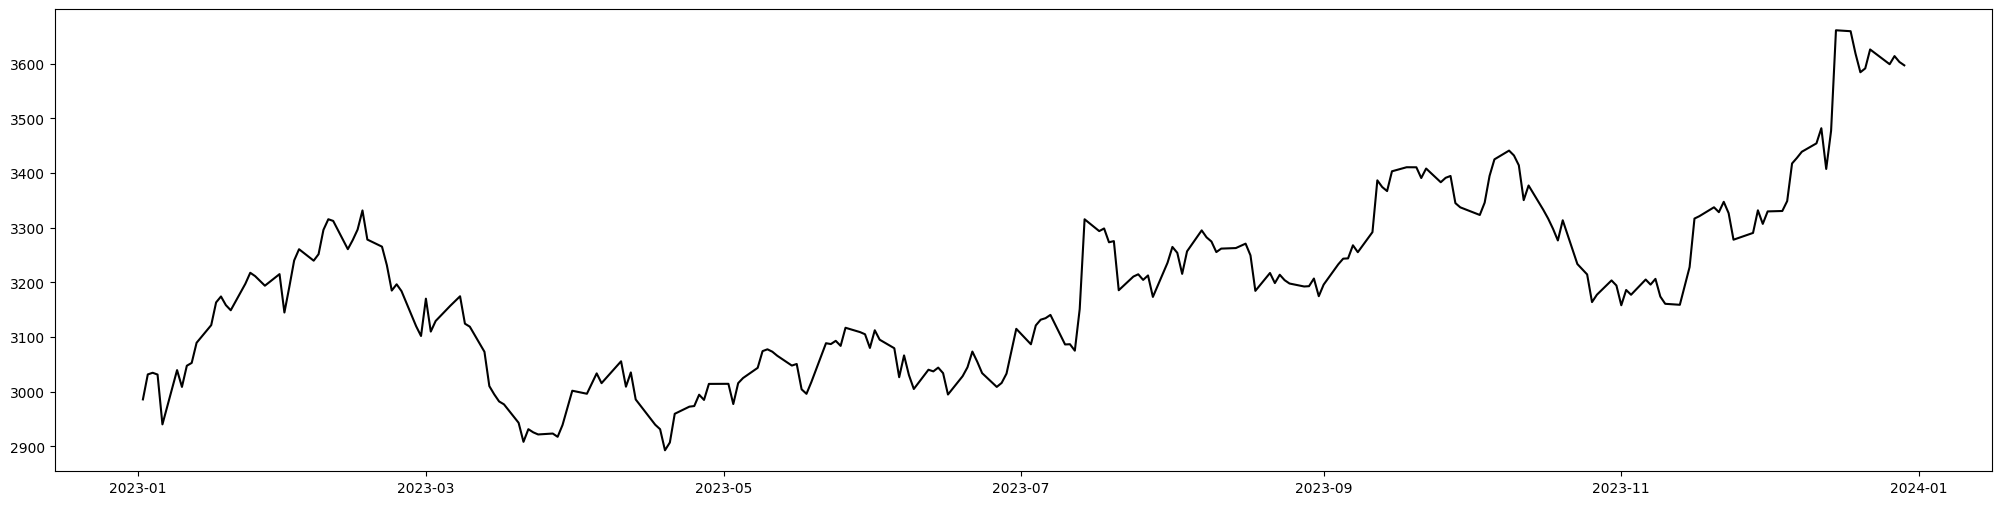

In [67]:
df = yf.download('TCS.NS', start='2023-01-01', end='2023-12-31', interval='1d', multi_level_index=False)

plt.figure(figsize=(25, 6))
plt.plot(df['Close'], color='black')

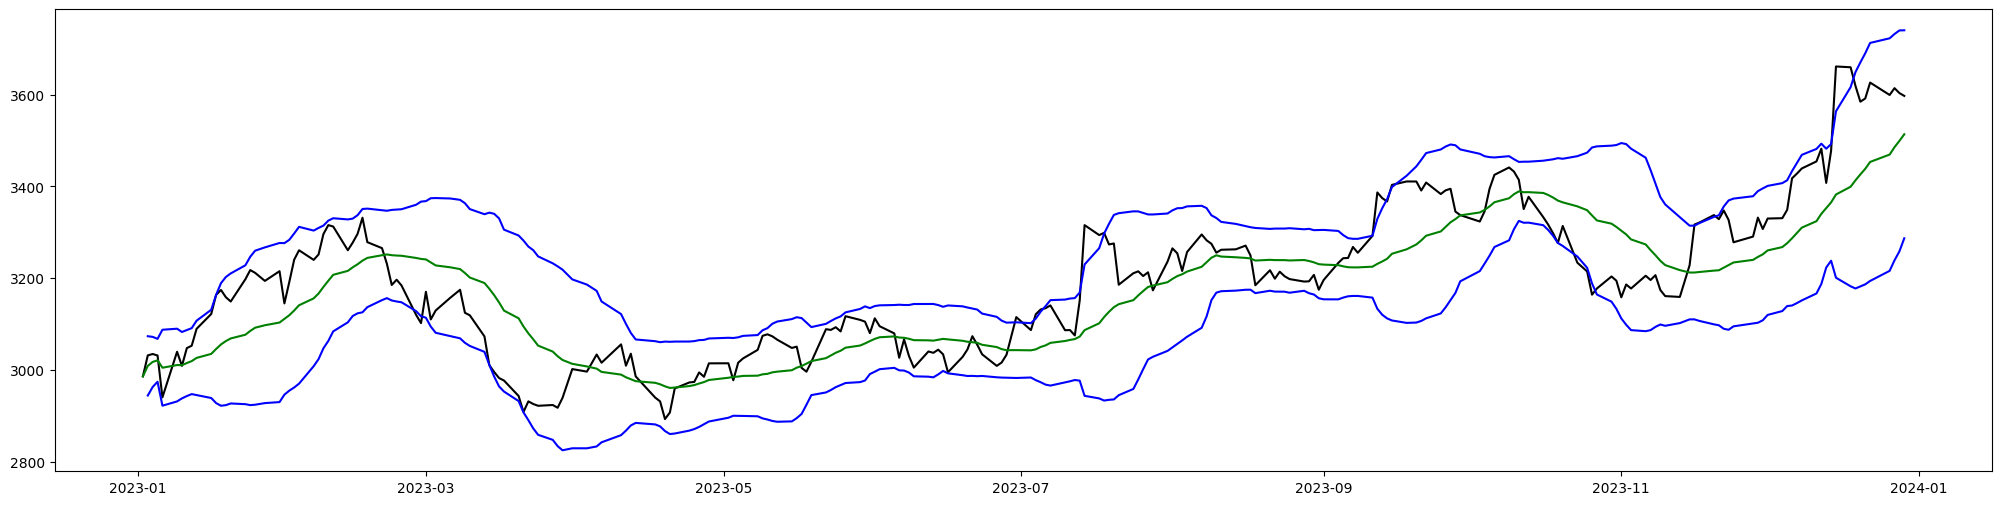

In [68]:
def bollinger_bands(df):
  df['Middle Band'] = df['Close'].rolling(window=20, min_periods=1).mean()
  df['20 STD'] = df['Close'].rolling(window=20, min_periods=1).std()
  df['Upper Band'] = df['Middle Band'] + (2 * df['20 STD'])
  df['Lower Band'] = df['Middle Band'] - (2 * df['20 STD'])
  return df

df = bollinger_bands(df)

plt.figure(figsize=(25, 6))
plt.plot(df['Close'], color='black')
plt.plot(df['Middle Band'], color='green')
plt.plot(df['Upper Band'], color='blue')
plt.plot(df['Lower Band'], color='blue')

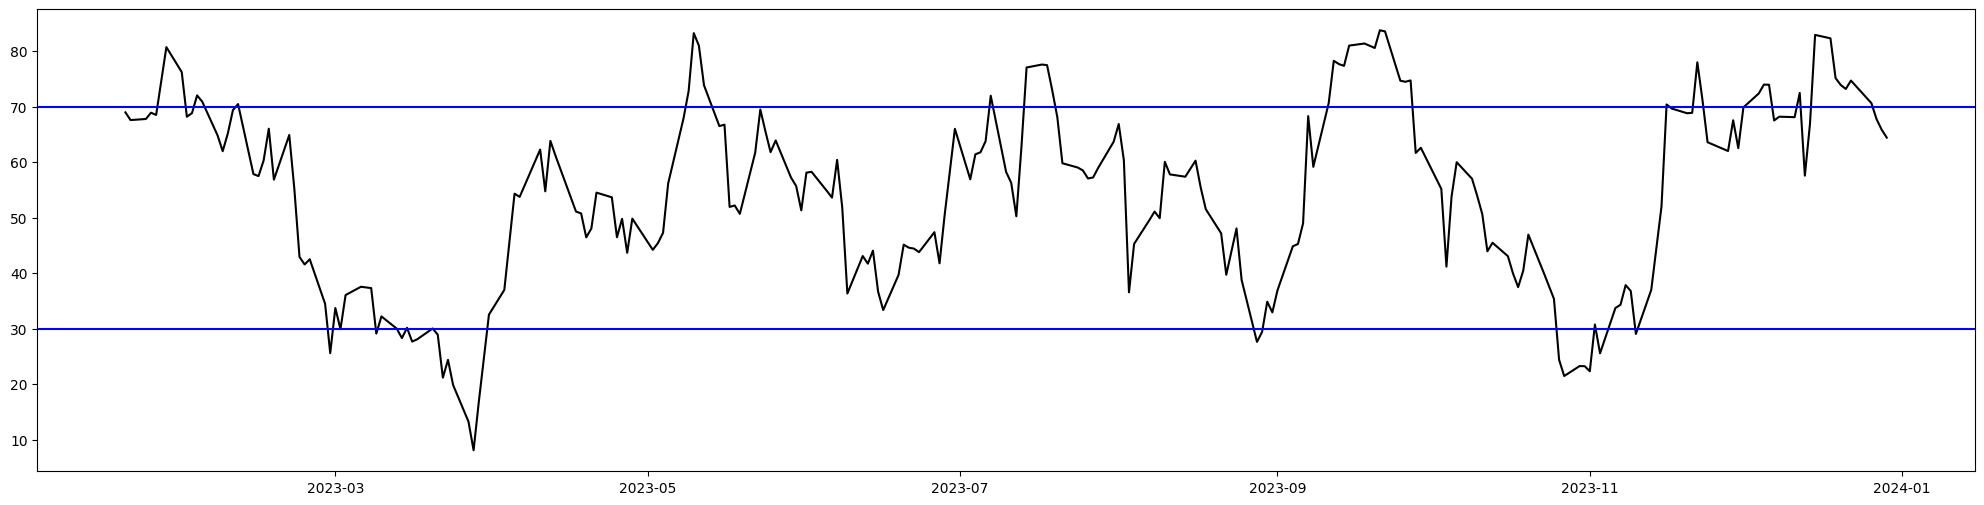

In [69]:
def rsi(df):
  df['Difference'] = df['Close'].diff()
  df['Gains'] = np.where(df['Difference'] > 0, df['Difference'], 0)
  df['Avg Gains'] = df['Gains'].rolling(window=14).mean()
  df['Loss'] = abs(np.where(df['Difference'] < 0, df['Difference'], 0))
  df['Avg Loss'] = df['Loss'].rolling(window=14).mean()
  df['RS'] = df['Avg Gains'] / df['Avg Loss']
  df['RSI'] = (1 - (1 / (1 + df['RS']))) * 100
  return df

df = rsi(df)

plt.figure(figsize=(25, 6))
plt.plot(df['RSI'], color='black')
plt.axhline(y=70, color='blue')
plt.axhline(y=30, color='blue')

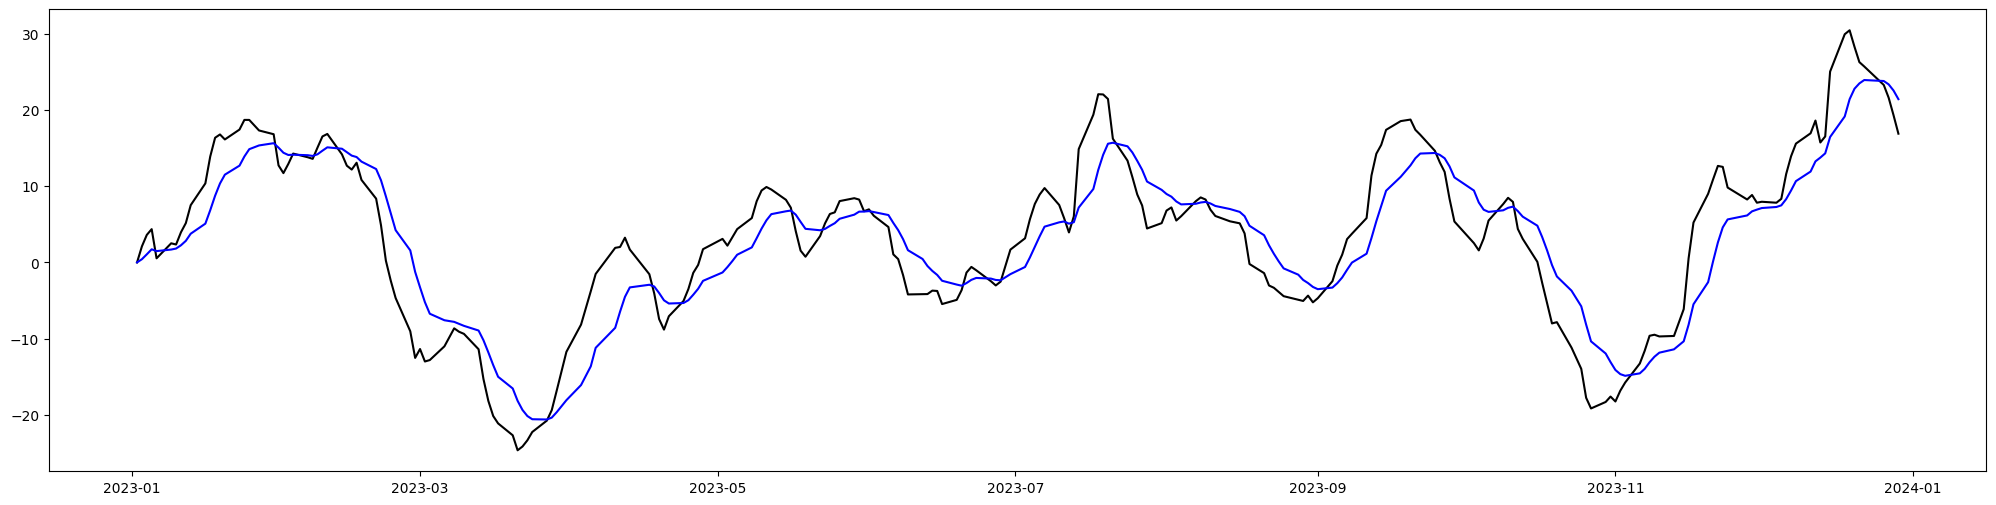

In [70]:
def macd(df):
  df['Short EMA'] = df['Close'].ewm(span=9, adjust=False).mean()
  df['Long EMA'] = df['Close'].ewm(span=12, adjust=False).mean()
  df['MACD'] = df['Short EMA'] - df['Long EMA']
  df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
  return df

df = macd(df)

plt.figure(figsize=(25, 6))
plt.plot(df['MACD'], color='black')
plt.plot(df['Signal Line'], color='blue')

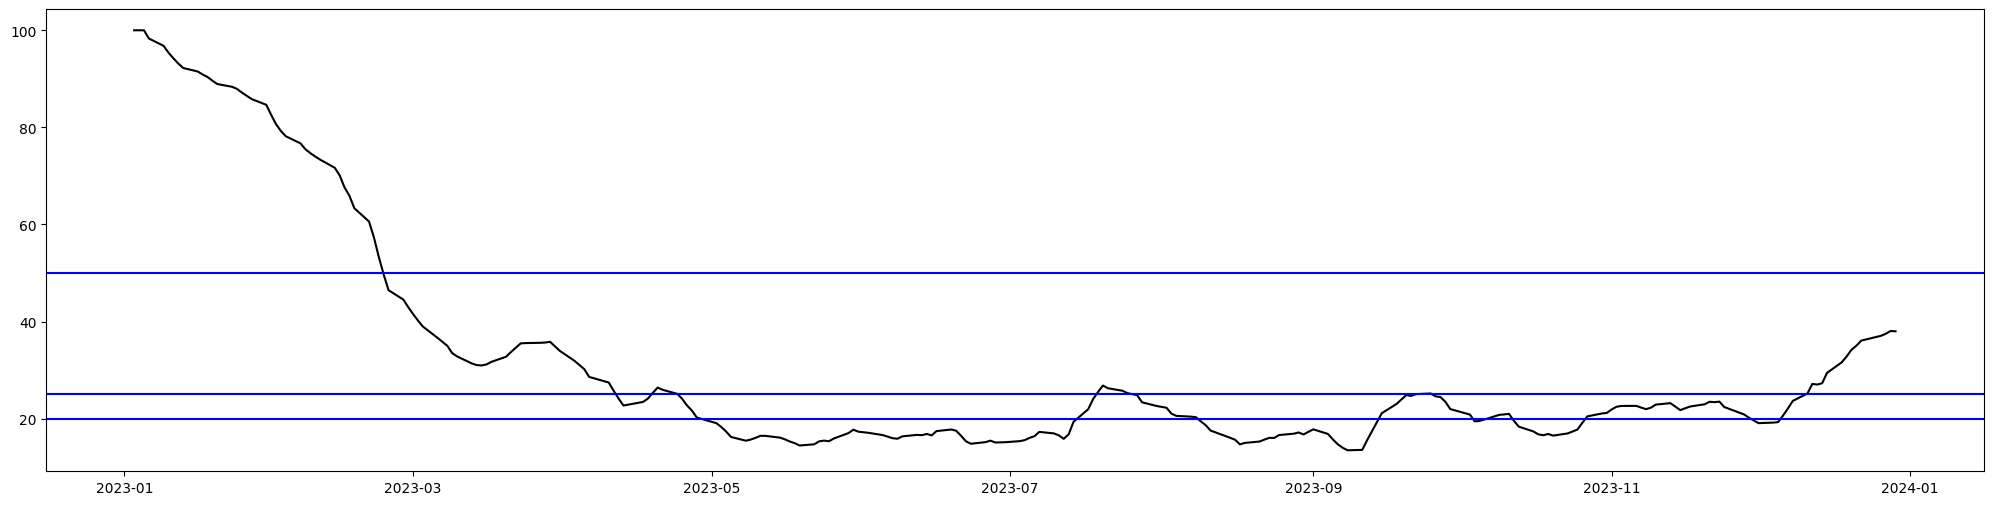

In [71]:
def adx(df):
  df['High Low Difference'] = df['High'] - df['Low']
  df['Prev High Low Difference'] = df['High'].shift(periods=1) - df['Low']
  df['High Prev Low Difference'] = df['High'] - df['Low'].shift(periods=1)
  df['True Range'] = np.abs(df[['High Low Difference', 'Prev High Low Difference', 'High Prev Low Difference']].max(axis=1))
  # Wilder's Smoothing - Uses 1 / period for Exponential Moving Average
  df['ATR'] = df['True Range'].ewm(alpha=1/14, adjust=False).mean()
  df['+DM'] = (df['High'] - df['High'].shift(periods=1)).clip(lower=0)
  df['-DM'] = (df['Low'].shift(periods=1) - df['Low']).clip(lower=0)
  df.loc[df['+DM'] < df['-DM'], '+DM'] = 0
  df.loc[df['-DM'] < df['+DM'], '-DM'] = 0
  df['Smooth +DM'] = df['+DM'].ewm(alpha=1/14, adjust=False).mean()
  df['Smooth -DM'] = df['-DM'].ewm(alpha=1/14, adjust=False).mean()
  df['+DI'] = df['Smooth +DM'] * df['ATR'] / 100
  df['-DI'] = df['Smooth -DM'] * df['ATR'] / 100
  df['DX'] = np.abs(df['+DI'] - df['-DI']) / np.abs(df['+DI'] + df['-DI']) * 100
  df['ADX']  = df['DX'].ewm(alpha=1/14, adjust=False).mean()
  return df

df = adx(df)

plt.figure(figsize=(25, 6))
plt.plot(df['ADX'], color='black')
plt.axhline(y=20, color='blue')
plt.axhline(y=25, color='blue')
plt.axhline(y=50, color='blue')

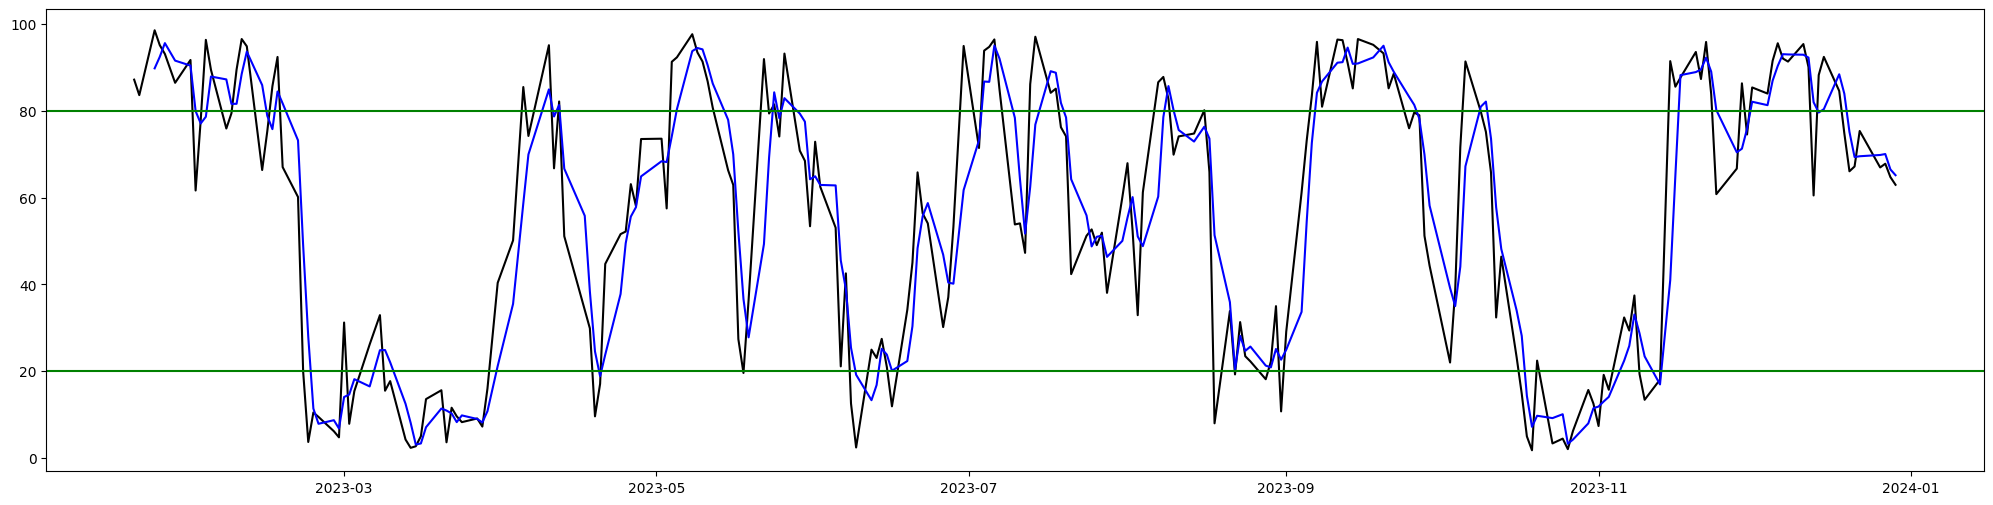

In [72]:
def stochastic_oscillator(df):
  df['Highest High'] = df['High'].rolling(window=14).max()
  df['Lowest Low'] = df['Low'].rolling(window=14).min()
  df['%K'] = ((df['Close'] - df['Lowest Low']) / (df['Highest High'] - df['Lowest Low'])) * 100
  df['%D'] = df['%K'].rolling(window=3).mean()
  return df

df = stochastic_oscillator(df)

plt.figure(figsize=(25, 6))
plt.plot(df['%K'], color='black')
plt.plot(df['%D'], color='blue')
plt.axhline(y=80, color='green')
plt.axhline(y=20, color='green')


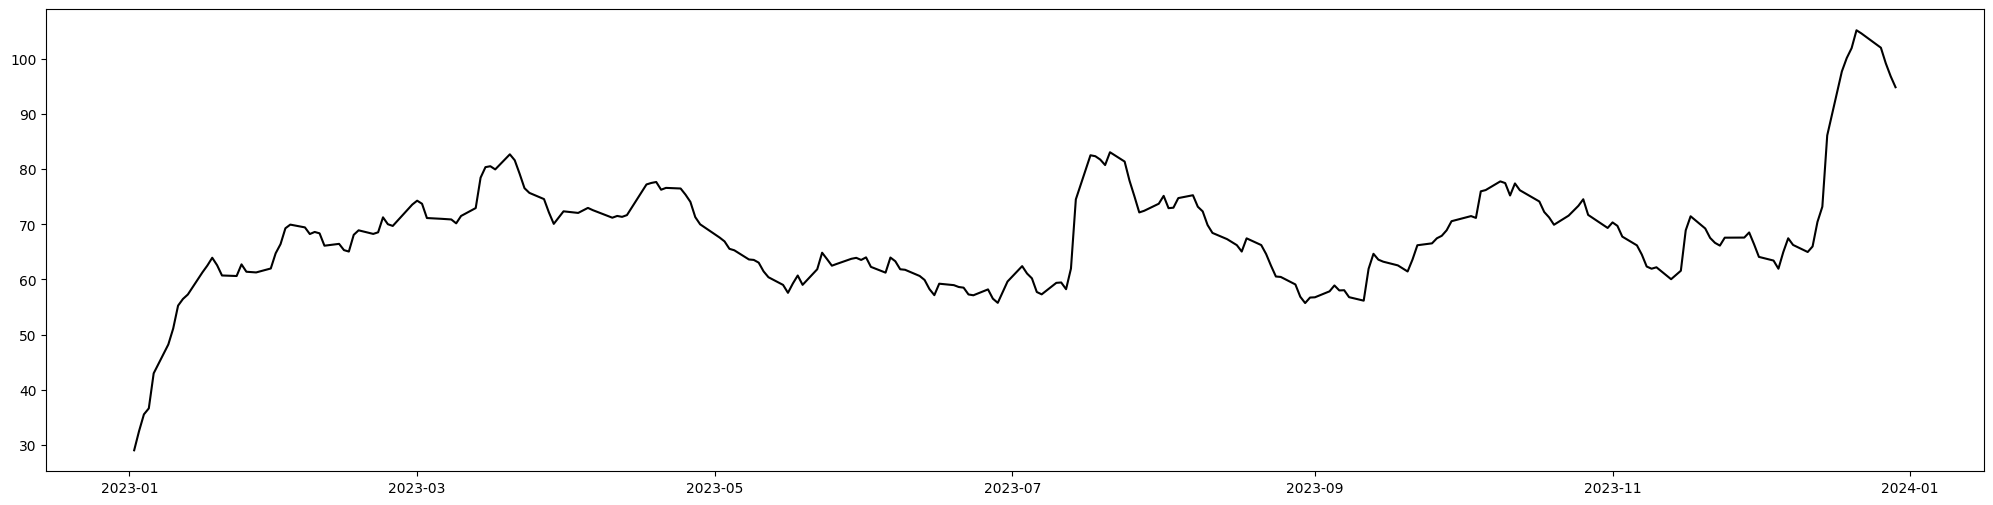

In [73]:
def atr(df):
  df['High Low Difference'] = df['High'] - df['Low']
  df['Prev High Low Difference'] = df['High'].shift(periods=1) - df['Low']
  df['High Prev Low Difference'] = df['High'] - df['Low'].shift(periods=1)
  df['True Range'] = np.abs(df[['High Low Difference', 'Prev High Low Difference', 'High Prev Low Difference']].max(axis=1))
  # Wilder's Smoothing - Uses 1 / period for Exponential Moving Average
  df['ATR'] = df['True Range'].ewm(alpha=1/14, adjust=False).mean()
  return df

df = atr(df)

plt.figure(figsize=(25, 6))
plt.plot(df['ATR'], color='black')

# Q2. Signal Generation

No. of buy signals: 6
No. of sell signals: 14


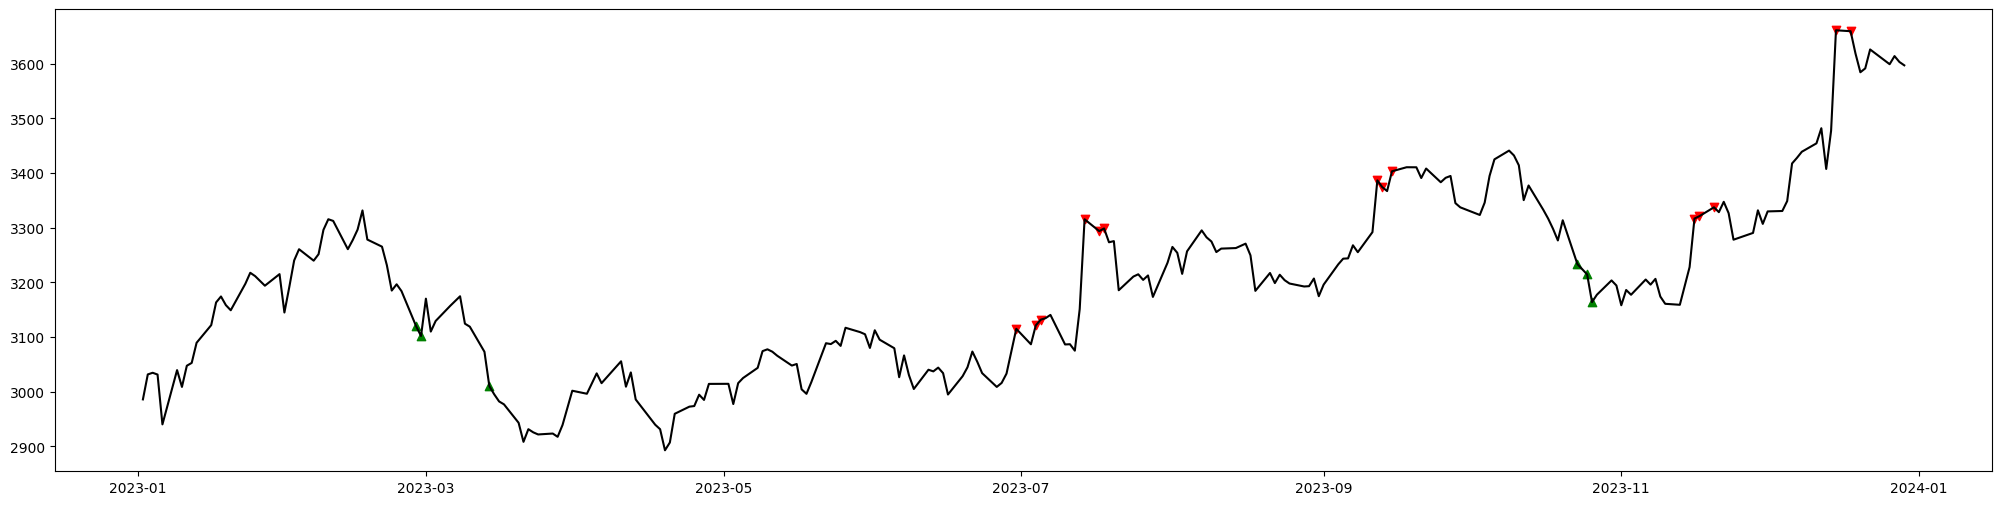

In [74]:
def bollinger_bands_signal(df):
  df = bollinger_bands(df)
  buy_signals = df[df['Close'] < df['Lower Band']]
  sell_signals = df[df['Close'] > df['Upper Band']]
  return buy_signals, sell_signals


buy_signals, sell_signals = bollinger_bands_signal(df)
print(f"No. of buy signals: {buy_signals.shape[0]}")
print(f"No. of sell signals: {sell_signals.shape[0]}")

plt.figure(figsize=(25, 6))
plt.plot(df['Close'], color='black')
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green')
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red')

No. of buy signals: 22
No. of sell signals: 40


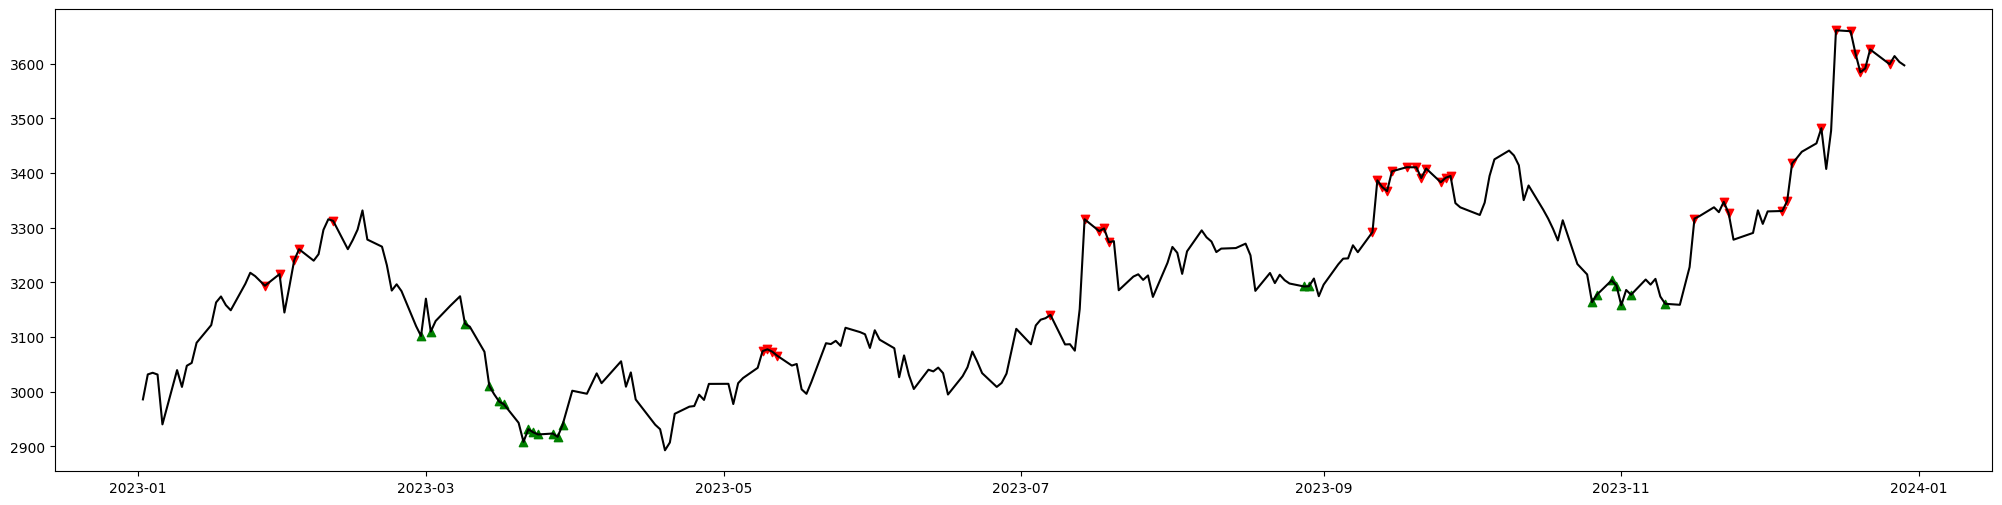

In [75]:
def rsi_signal(df):
  df = rsi(df)
  buy_signals = df[df['RSI'] < 30]
  sell_signals = df[df['RSI'] > 70]
  return buy_signals, sell_signals

buy_signals, sell_signals = rsi_signal(df)
print(f"No. of buy signals: {buy_signals.shape[0]}")
print(f"No. of sell signals: {sell_signals.shape[0]}")

plt.figure(figsize=(25, 6))
plt.plot(df['Close'], color='black')
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green')
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red')

No. of buy signals: 129
No. of sell signals: 115


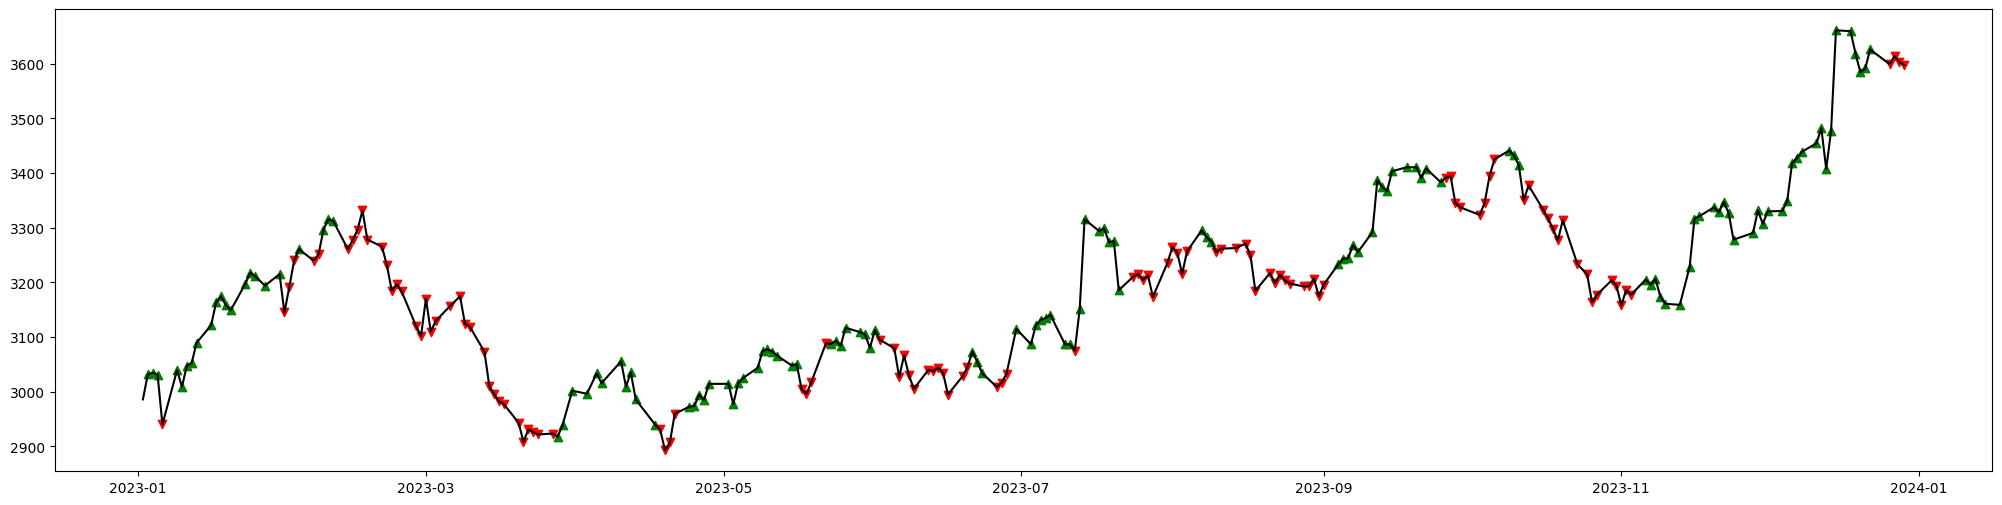

In [76]:
def macd_signal(df):
  df = macd(df)
  buy_signals = df[df['MACD'] > df['Signal Line']]
  sell_signals = df[df['MACD'] < df['Signal Line']]
  return buy_signals, sell_signals

buy_signals, sell_signals = macd_signal(df)
print(f"No. of buy signals: {buy_signals.shape[0]}")
print(f"No. of sell signals: {sell_signals.shape[0]}")

plt.figure(figsize=(25, 6))
plt.plot(df['Close'], color='black')
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green')
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red')

No. of trend signals: 92


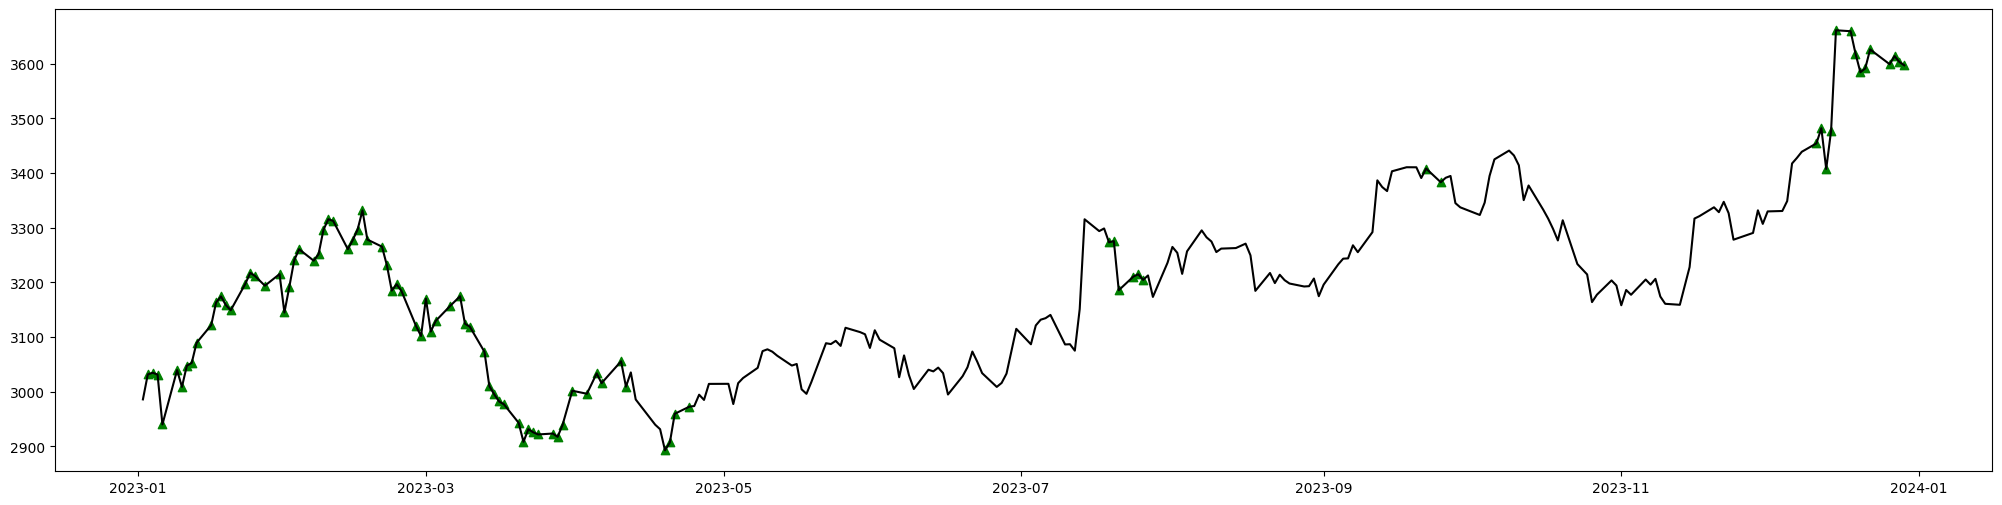

In [77]:
# ADX is a trend indicator and hence only gives a sense of whether a trend is present or not.
# The trend could be bullish or bearish.
def adx_signal(df):
  df = adx(df)
  trend_signals = df[df['ADX'] > 25]
  return trend_signals

trend_signals = adx_signal(df)
print(f"No. of trend signals: {trend_signals.shape[0]}")

plt.figure(figsize=(25, 6))
plt.plot(df['Close'], color='black')
plt.scatter(trend_signals.index, trend_signals['Close'], marker='^', color='green')

No. of buy signals: 38
No. of sell signals: 66


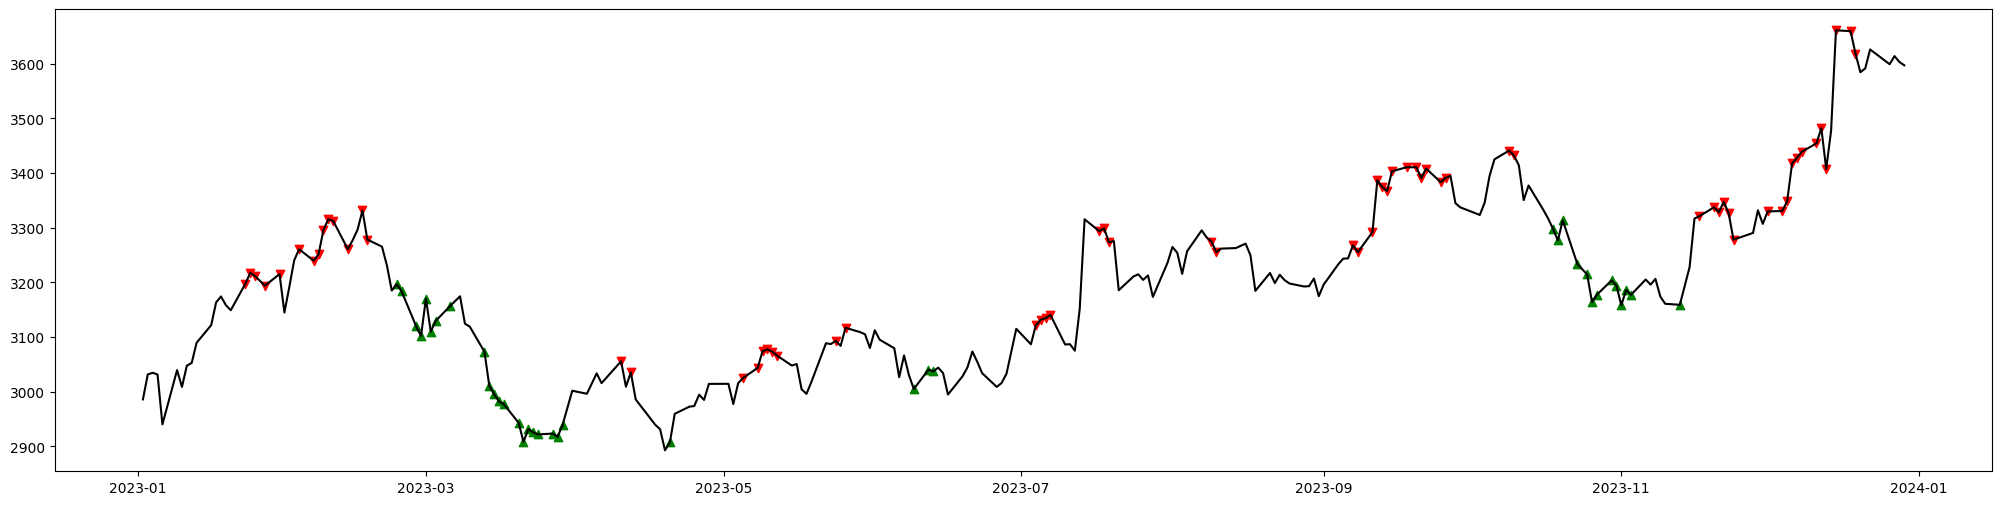

In [78]:
def so_signal(df):
  df = stochastic_oscillator(df)
  buy_signals = df[df['%D'] < 20]
  sell_signals = df[df['%D'] > 80]
  return buy_signals, sell_signals

buy_signals, sell_signals = so_signal(df)
print(f"No. of buy signals: {buy_signals.shape[0]}")
print(f"No. of sell signals: {sell_signals.shape[0]}")

plt.figure(figsize=(25, 6))
plt.plot(df['Close'], color='black')
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green')
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red')

No. of volatile signals: 93


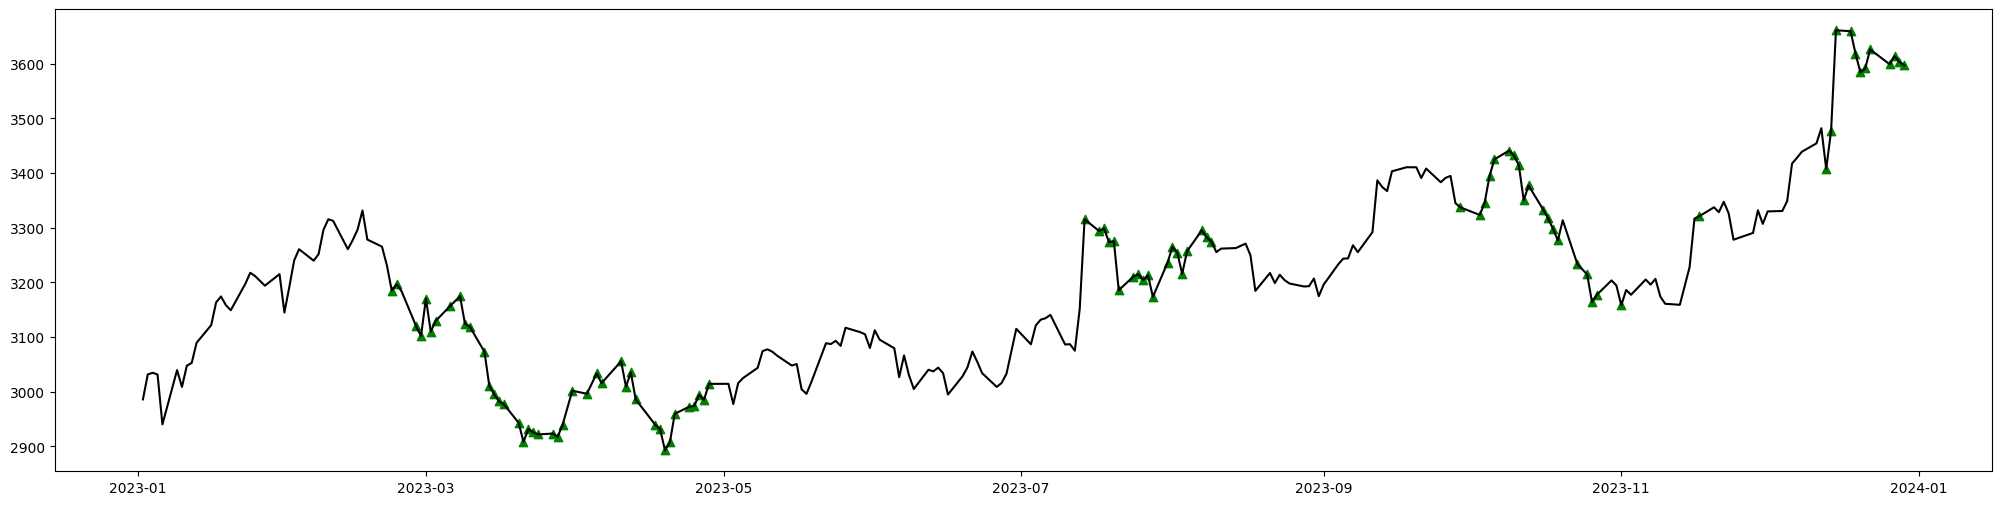

In [79]:
# ATR shows market volatility and hence only helps decide if an indicator is more reliable or not.
def atr_signal(df):
  df = atr(df)
  volatile_signals = df[df['ATR'] > 70]
  return volatile_signals

volatile_signals = atr_signal(df)
print(f"No. of volatile signals: {volatile_signals.shape[0]}")

plt.figure(figsize=(25, 6))
plt.plot(df['Close'], color='black')
plt.scatter(volatile_signals.index, volatile_signals['Close'], marker='^', color='green')
